In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [29]:
!pip install scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve,
    mean_absolute_error, mean_squared_error
)

## **Loading the dataset**

In [ ]:
df = pd.read_csv('Airline_Delay_Cause.csv')
df = df.dropna()

In [ ]:
# Target Columns
df['is_delayed'] = (df['arr_del15']> 0).astype(int) # Classification label
df['OAI'] = df['carrier_delay'] + df['late_aircraft_delay'] # for regression custom metric

In [52]:
# Feature selection
features = ['month', 'arr_flights', 'carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']
X = df[features]
y_class = df['is_delayed']
y_reg = df['arr_delay']

In [61]:
# Train-test split
X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)
_, _, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Create TotalDelay column by summing up delay components
df['TotalDelay'] = df['carrier_delay'] + df['weather_delay'] + df['nas_delay'] + df['security_delay'] + df['late_aircraft_delay']

# Define binary target (1 = Delayed, 0 = Not Delayed)
df['is_delayed'] = df['TotalDelay'].apply(lambda x: 1 if x > 15 else 0)

## **Classification Model (Yes/No)**

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train_class)
y_pred_class = clf.predict(X_test)
y_proba_class = clf.predict_proba(X_test)[:, 1]

In [41]:
## Metrics
print("Classification Metrics:")
print("Accuracy:", accuracy_score(y_test_class, y_pred_class))
print("Precision:", precision_score(y_test_class, y_pred_class))
print("Recall:", recall_score(y_test_class, y_pred_class))
print("F1 Score:", f1_score(y_test_class, y_pred_class))
print("ROC AUC Score:", roc_auc_score(y_test_class, y_proba_class))

Classification Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC Score: 1.0


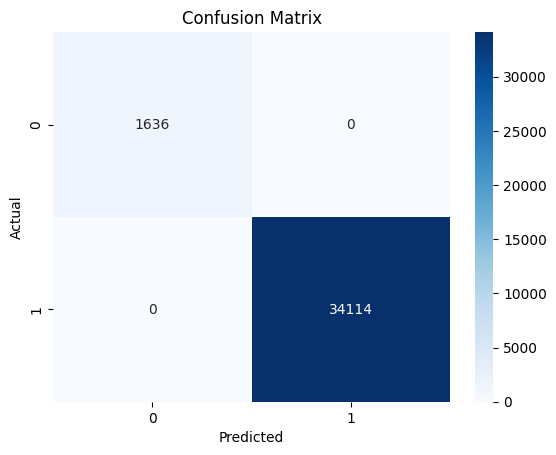

In [37]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# True Negatives (Top-Left: 1636) — The model correctly predicted 1636 flights as NOT delayed.
# True Positives (Bottom-Right: 34114) — The model correctly predicted 34114 flights as delayed.

# False Negatives & False Positives are both 0 — this indicates perfect classification performance on the test set.
# Such a result often signals possible data imbalance or model overfitting, and may need further validation.

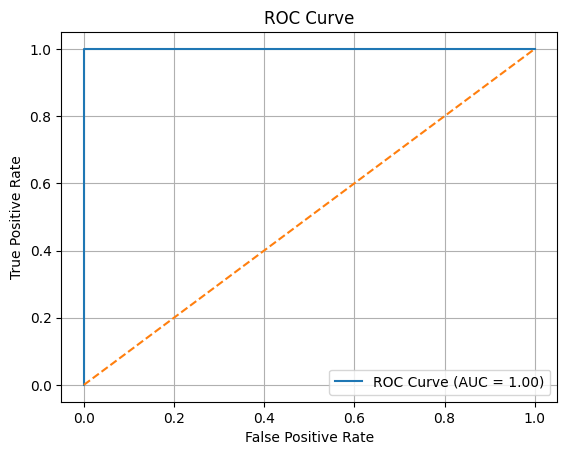

In [38]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test_class, y_proba_class)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test_class, y_proba_class)))
plt.plot([0, 1], [0, 1], '--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# The ROC curve shows the trade-off between True Positive Rate (TPR) and False Positive Rate (FPR).
# A curve reaching the top-left corner (as seen here) indicates excellent classification performance.

# AUC (Area Under Curve) = 1.00 means the model perfectly separates the classes — every delayed vs. non-delayed flight
# is correctly identified without any misclassification.

# Note: A perfect AUC might be unrealistic and may indicate overfitting, so cross-validation is recommended.

## **Regression Model (Delay Duration)**

In [39]:
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train, y_train_reg)
y_pred_reg = reg.predict(X_test)

print("Regression Metrics:")
print("MAE:", mean_absolute_error(y_test_reg, y_pred_reg))
print("RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))

Regression Metrics:
MAE: 687.3640357549917
RMSE: 2271.5855834654303


In [66]:
# Showing actual vs. predicted delay (first 10)
regression_results = pd.DataFrame({
    'Actual Delay (min)': y_test_reg.values,
    'Predicted Delay (min)': y_pred_reg
})

regression_results.head(10)

,Actual Delay (min),Predicted Delay (min)
0,304.0,302.580000
1,3294.0,3989.810000
2,304.0,422.670000
3,237.0,173.895000
4,104.0,124.037833
5,1937.0,2244.240000
6,642.0,751.670000
7,170.0,407.030000
8,5120.0,3845.680000
9,254.0,118.472667


In [ ]:
# This table shows a comparison between actual delay durations and the predicted values from the Random Forest Regressor.
# While some predictions are quite close (e.g., row 0), others show significant deviation, especially for longer delays.

# The model seems to generally capture the trend of delay magnitude, but struggles with extreme values — likely due to their rarity or noise in those cases.

# This aligns with the evaluation metrics (MAE ≈ 687, RMSE ≈ 2271), indicating reasonably good average performance but some large individual errors.

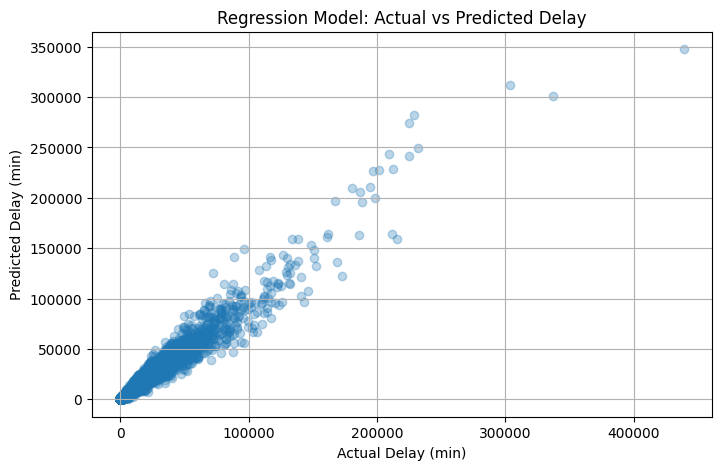

In [65]:
plt.figure(figsize=(8,5))
plt.scatter(y_test_reg.values, y_pred_reg, alpha=0.3)
plt.xlabel("Actual Delay (min)")
plt.ylabel("Predicted Delay (min)")
plt.title("Regression Model: Actual vs Predicted Delay")
plt.grid(True)
plt.show()

In [ ]:
# This scatter plot compares actual delay durations (X-axis) with the predicted values (Y-axis) from the regression model.

# The ideal scenario would be all points lying perfectly along the diagonal (y = x), indicating perfect prediction.
# In this case, most points cluster close to the diagonal, suggesting strong predictive performance overall.

# However, there are some deviations — particularly for extreme delay durations — where the model struggles slightly, 
# which is common in real-world regression due to data imbalance or variance in long delays.

## **OAI-Based Evaluation (Custom Metric)**

In [50]:
# Re-calculate OAI delay value from test set (true vs predicted)
y_test_oai = df.loc[y_test_reg.index, ['carrier_delay', 'late_aircraft_delay']].sum(axis=1).values
y_pred_oai = reg.predict(X_test)

In [51]:
# OAI score = MAE on controllable delays
oai_score = mean_absolute_error(y_test_oai, y_pred_oai)
print("OAI (Operational Adjustability Index) MAE:", round(oai_score, 2))

OAI (Operational Adjustability Index) MAE: 1199.67
